In [55]:
from qiskit import *
from qiskit.visualization import *
from qiskit.circuit.library import MCMT

from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

import numpy as np
import matplotlib.pyplot as plt
import math

sim = Aer.get_backend('qasm_simulator')

# using tikzplotlib to export plot to latex
import tikzplotlib

def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

def save_fig(name, width='10cm', height='10cm'):
    fig = plt.gcf()
    tikzplotlib_fix_ncols(fig)

    tikzplotlib.clean_figure()
    tikzplotlib.save(name + '.tex', axis_width=width, axis_height=height)

In [56]:
sudoku4 = [[1, 0, 0, 0],
          [0, 0, 0, 4],
          [0, 0, 2, 0],
          [0, 3, 0, 0]]
sudoku2 = [[0, 0],
          [0, 0]]

In [57]:
def calc_inconnue(grid):
    size = len(bin(len(grid)-1).replace("0b", ""))
    donnees = 0
    for k in range(len(grid)):
        for j in range(len(grid)):
            if grid[k][j] != 0:
                donnees += 1

    inconnue = (len(grid)**2 - donnees) * size   
    return inconnue

print(calc_inconnue(sudoku2))
print(calc_inconnue(sudoku4))

4
24


In [58]:
def calc_cond(grid):
    size = len(bin(len(grid)-1).replace("0b", ""))
    cond_c = (len(grid) * (len(grid) - 1) / 2) * size * len(grid)
    if len(grid) >= 4 and np.sqrt(len(grid)).is_integer():
        cond_square = cond_c
    else:
        cond_square = 0
        
    return int(2 * cond_c + cond_square)

print(calc_cond(sudoku2))
print(calc_cond(sudoku4))

4
144


In [59]:
def calc_verif(grid, cond):
    size = len(bin(len(grid)-1).replace("0b", ""))
    verif_out = 0
    prev_cond = cond
    for k in range(size - 1):
        verif_out += prev_cond/2
        prev_cond = prev_cond/2
        
    return int(verif_out)

print(calc_verif(sudoku2, calc_cond(sudoku2)))
print(calc_verif(sudoku4, calc_cond(sudoku4)))

0
72


In [60]:
sudoku = sudoku2

inc = calc_inconnue(sudoku)
tot_cond = calc_cond(sudoku)
verif = calc_verif(sudoku, tot_cond)

num_rep = int(np.floor(np.pi / 4 * np.sqrt(2**inc))-1)

print("Nombre de répétitions : ", num_rep)
print("Nombre de qubits : ", inc + tot_cond + verif)

Nombre de répétitions :  2
Nombre de qubits :  8


In [61]:
entry = QuantumRegister(inc, 'entry')
cond = QuantumRegister(tot_cond, 'cond')
ver = QuantumRegister(verif, 'verif')
out = QuantumRegister(1, 'out')

In [62]:
def diffuser(nqubits):
    qc_diff = QuantumCircuit(nqubits)
    qc_diff.h(range(nqubits))
    qc_diff.x(range(nqubits))

    qc_diff.barrier()

    qc_diff.h(nqubits - 1)
    qc_diff.mct(list(range(nqubits - 1)), nqubits - 1)
    qc_diff.h(nqubits - 1)
    
    qc_diff.barrier()

    qc_diff.x(range(nqubits))
    qc_diff.h(range(nqubits))
    
    return qc_diff

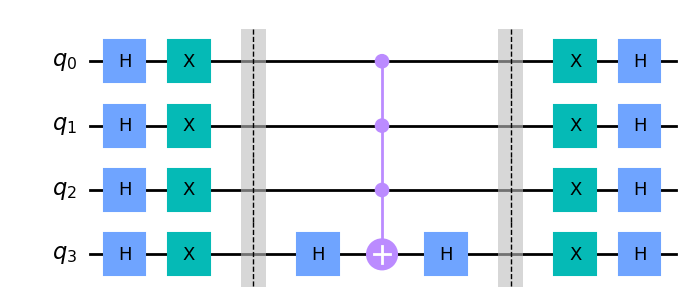

In [63]:
diffuser(inc).draw('mpl')

In [64]:
print(diffuser(inc).draw('latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{H}} & \gate{\mathrm{X}} \barrier[0em]{3} & \qw & \qw & \ctrl{1} & \qw \barrier[0em]{3} & \qw & \gate{\mathrm{X}} & \gate{\mathrm{H}} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \gate{\mathrm{H}} & \gate{\mathrm{X}} & \qw & \qw & \ctrl{1} & \qw & \qw & \gate{\mathrm{X}} & \gate{\mathrm{H}} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \gate{\mathrm{H}} & \gate{\mathrm{X}} & \qw & \qw & \ctrl{1} & \qw & \qw & \gate{\mathrm{X}} & \gate{\mathrm{H}} & \qw & \qw\\
	 	\nghost{{q}_{3} :  } & \lstick{{q}_{3} :  } & \gate{\mathrm{H}} & \gate{\mathrm{X}} & \qw & \gate{\mathrm{H}} & \targ & \gate{\mathrm{H}} & \qw & \gate{\mathrm{X}} & \gate{\mathrm{H}} & \qw & \qw\\
\\ }}
\end{document}


In [65]:
# n-1 en bin comme sortie

def grid_check(line, col):
    for k in range(line):
        for j in range(col):
            if (line % np.sqrt(len(sudoku))) == k and (col % np.sqrt(len(sudoku))) == j:
                return k + j

def sudoku_oracle(sudoku_grid):
    num_empty = 0
    size = len(bin(len(sudoku_grid)-1).replace("0b", ""))

    if len(sudoku_grid) >= 4 and np.sqrt(len(sudoku_grid)).is_integer():
        div_cond = 3
    else:
        div_cond = 2

    qc_oracle = QuantumCircuit(entry, cond, ver, out)

    for grid_line in range(len(sudoku_grid)):
        for grid_column in range(len(sudoku_grid[grid_line])):
            # conditions for line and column
            if sudoku_grid[grid_line][grid_column] == 0:
                for j in range(size):
                    qc_oracle.cx(entry[num_empty + j], cond[int(size * grid_column + (len(sudoku_grid) * (len(sudoku_grid) - 1) / 2) * size * grid_line)])
            else:
                bit = bin(sudoku_grid[grid_line][grid_column] - 1).replace("0b", "")
                for j in range(len(bit)):
                    if bit[j] == '1':
                        qc_oracle.x(cond[int(size * grid_column + (len(sudoku_grid) * (len(sudoku_grid) - 1) / 2) * size * grid_line + j)])

            if sudoku_grid[grid_line][grid_column] == 0:
                for j in range(size):
                    qc_oracle.cx(entry[num_empty + j], cond[int(size * grid_line + (len(sudoku_grid) * (len(sudoku_grid) - 1) / 2) * size * grid_column + (tot_cond/div_cond - 1))])
            else:
                bit = bin(sudoku_grid[grid_line][grid_column] - 1).replace("0b", "")
                for j in range(len(bit)):
                    if bit[j] == '1':
                        qc_oracle.x(cond[int(size * grid_line + (len(sudoku_grid) * (len(sudoku_grid) - 1) / 2) * size * grid_column + (tot_cond/div_cond-1) + j)])            

            # conditions for square
            if div_cond == 3:    
                if sudoku_grid[grid_line][grid_column] == 0:
                    for j in range(size):
                        qc_oracle.cx(entry[num_empty + j], cond[int(2 * grid_check(grid_line, grid_column) + tot_cond/div_cond * 2 + (len(sudoku_grid) * (len(sudoku_grid) - 1) / 2) * size * grid_check(grid_line, grid_column))])
                else:
                    for bit in bin(sudoku_grid[grid_line][grid_column] - 1).replace("0b", ""):
                        if bit == '1':
                            qc_oracle.x(cond[int(2 * grid_check(grid_line, grid_column) + tot_cond/div_cond * 2 + (len(sudoku_grid) * (len(sudoku_grid) - 1) / 2) * size * grid_check(grid_line, grid_column))])
             

            if sudoku_grid[grid_line][grid_column] == 0:
                num_empty += size

    for j in range(size):
        if j == 0:
            for k in range(verif):
                if 2*k < tot_cond:
                    qc_oracle.cx(cond[2 * k], ver[k])
                    qc_oracle.cx(cond[2 * k + 1], ver[k])
        else:
            for k in range(verif):
                if 2*k < tot_cond * j / 2**j:
                    qc_oracle.cx(verif[int(2 * k + tot_cond * j / 2 ** j)], ver[k])
                    qc_oracle.cx(verif[int(2 * k + 1 + tot_cond * j / 2 ** j)], ver[k])

    qc_rep = qc_oracle.to_gate(label='rep')
    if verif != 0:
        qc_oracle.compose(MCMT('x', verif, 1), range(inc + tot_cond, inc + tot_cond + verif + 1), inplace=True)
    else:
        qc_oracle.compose(MCMT('x', tot_cond, 1), range(inc, inc + tot_cond + 1), inplace=True)
        
    qc_oracle.append(qc_rep, entry[:] + cond[:] + ver[:] + out[:])

    return qc_oracle   

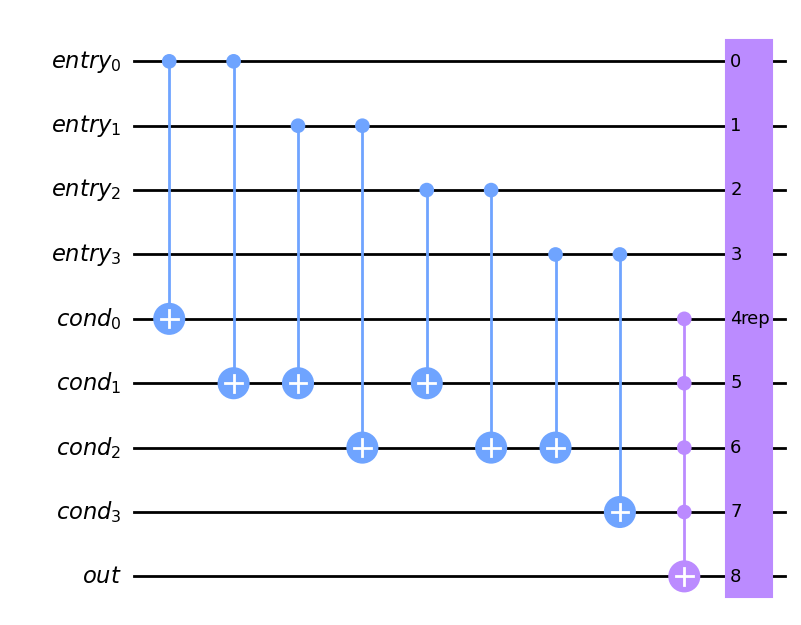

In [66]:
sudoku_oracle(sudoku2).draw('mpl')

In [67]:
print(sudoku_oracle(sudoku2).draw('latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{entry}_{0} :  } & \lstick{{entry}_{0} :  } & \ctrl{4} & \ctrl{5} & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \multigate{8}{\mathrm{rep}}_<<<{0} & \qw & \qw\\
	 	\nghost{{entry}_{1} :  } & \lstick{{entry}_{1} :  } & \qw & \qw & \ctrl{4} & \ctrl{5} & \qw & \qw & \qw & \qw & \qw & \ghost{\mathrm{rep}}_<<<{1} & \qw & \qw\\
	 	\nghost{{entry}_{2} :  } & \lstick{{entry}_{2} :  } & \qw & \qw & \qw & \qw & \ctrl{3} & \ctrl{4} & \qw & \qw & \qw & \ghost{\mathrm{rep}}_<<<{2} & \qw & \qw\\
	 	\nghost{{entry}_{3} :  } & \lstick{{entry}_{3} :  } & \qw & \qw & \qw & \qw & \qw & \qw & \ctrl{3} & \ctrl{4} & \qw & \ghost{\mathrm{rep}}_<<<{3} & \qw & \qw\\
	 	\nghost{{cond}_{0} :  } & \lstick{{cond}_{0} :  } & \targ & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \ctrl{1} & \ghost{\mathrm{rep}}_<<<{4} & \qw & \qw\\
	 	\nghost{{cond

In [68]:
from qiskit.transpiler.passes import RemoveBarriers

print('début 0/?')
oracle_gate = sudoku_oracle(sudoku).to_gate(label='oracle')
print('oracle construit 1/?')
diffuser_gate = RemoveBarriers()(diffuser(inc)).to_gate(label='diffuser')
print('diffuser construit 2/?')

output = ClassicalRegister(inc, 'output')
print('creation output 3/?')

qc_total = QuantumCircuit(entry, cond, ver, out, output)
print('qc_total construit 4/?')

qc_total.h(entry)
print('qc_total h 5/?')

qc_total.barrier()
print('qc_total barrier 6/?')

for i in range(num_rep):
    qc_total.append(oracle_gate, entry[:] + cond[:] + ver[:] + out[:])
    print('qc_total oracle 7/? :', i)
    qc_total.append(diffuser_gate, entry[:])
    print('qc_total diffuser 8/? :', i)

qc_total.measure(entry, output)
print('qc_total measure 9/?')

début 0/?
oracle construit 1/?
diffuser construit 2/?
creation output 3/?
qc_total construit 4/?
qc_total h 5/?
qc_total barrier 6/?
qc_total oracle 7/? : 0
qc_total diffuser 8/? : 0
qc_total oracle 7/? : 1
qc_total diffuser 8/? : 1
qc_total measure 9/?


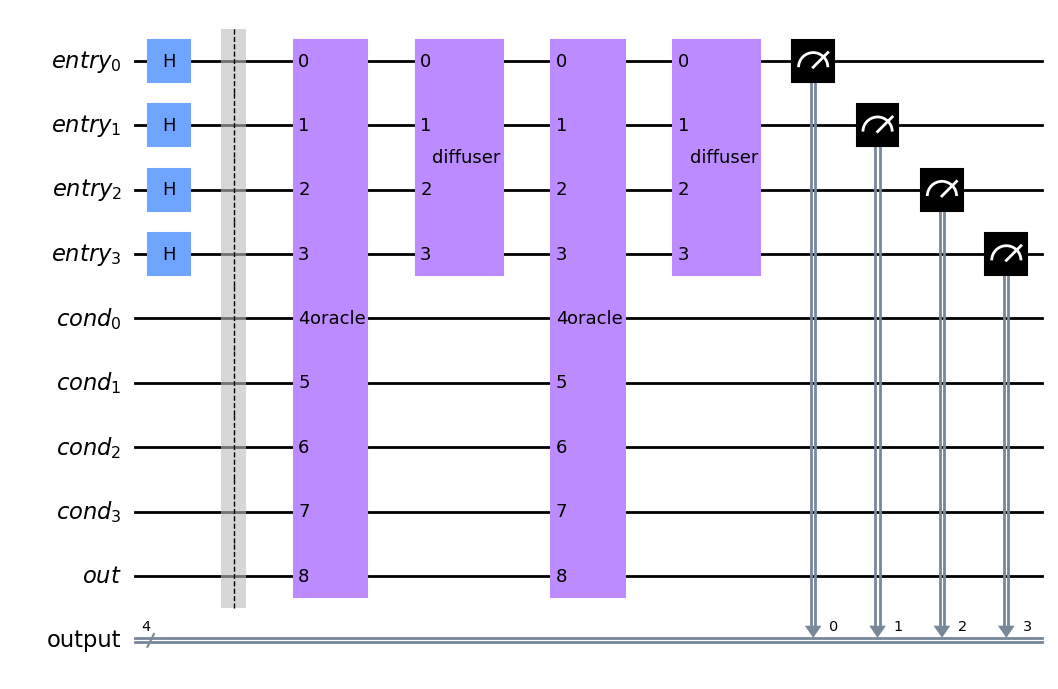

In [69]:
qc_total.draw('mpl')

In [70]:
print(qc_total.draw(output='latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{entry}_{0} :  } & \lstick{{entry}_{0} :  } & \gate{\mathrm{H}} \barrier[0em]{8} & \qw & \multigate{8}{\mathrm{oracle}}_<<<{0} & \multigate{3}{\mathrm{diffuser}}_<<<{0} & \multigate{8}{\mathrm{oracle}}_<<<{0} & \multigate{3}{\mathrm{diffuser}}_<<<{0} & \meter & \qw & \qw & \qw & \qw & \qw\\
	 	\nghost{{entry}_{1} :  } & \lstick{{entry}_{1} :  } & \gate{\mathrm{H}} & \qw & \ghost{\mathrm{oracle}}_<<<{1} & \ghost{\mathrm{diffuser}}_<<<{1} & \ghost{\mathrm{oracle}}_<<<{1} & \ghost{\mathrm{diffuser}}_<<<{1} & \qw & \meter & \qw & \qw & \qw & \qw\\
	 	\nghost{{entry}_{2} :  } & \lstick{{entry}_{2} :  } & \gate{\mathrm{H}} & \qw & \ghost{\mathrm{oracle}}_<<<{2} & \ghost{\mathrm{diffuser}}_<<<{2} & \ghost{\mathrm{oracle}}_<<<{2} & \ghost{\mathrm{diffuser}}_<<<{2} & \qw & \qw & \meter & \qw & \qw & \qw\\
	 	\nghost{{en

In [71]:
# from qiskit import IBMQ
# 
# # IBMQ.save_account(TOKEN)
# IBMQ.load_account() # Load account from disk
# IBMQ.providers()    # List all available providers
# 
# provider = IBMQ.get_provider(hub='ibm-q')
# provider.backends()
# 
# backend = provider.get_backend('simulator_mps')

In [72]:
print('debut')
trans_qc = transpile(qc_total, backend=sim)
print('transpile done')
results = execute(trans_qc, backend=sim, shots=512).result()
print('execute done')
counts = results.get_counts()
plot_histogram(counts)

debut


MemoryError: Unable to allocate 32.0 GiB for an array with shape (65536, 65536) and data type float64

In [ ]:
with open('out.txt', 'w+') as f:
    print(counts, file=f)

plt.figure(figsize=(10, 10))
plt.barh(list(counts.keys()), list(counts.values()))
save_fig('sudoku_result')